## Exercise 3
#### In this exercise, we will  solve a multi-class classification task with different types of Neural Networks using PyTorch.
 
### import all packages


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transformation
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random  as rnd
from sklearn.model_selection import train_test_split 
np.random.seed(208520262)  

### Visualize the Data

Files already downloaded and verified


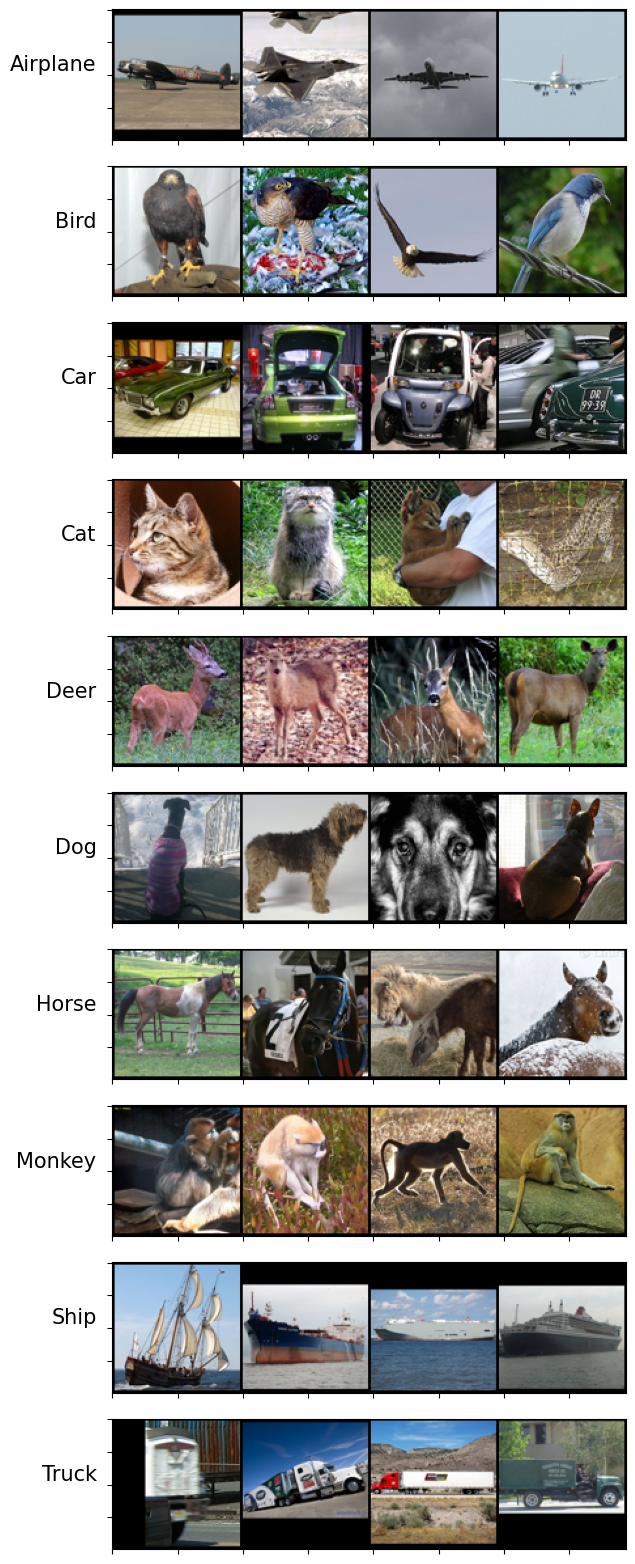

In [52]:
# create true labels
true_labels =  ["Airplane",  # index 0
                "Bird",      # index 1
                "Car",       # index 2 
                "Cat",       # index 3 
                "Deer",      # index 4
                "Dog",       # index 5
                "Horse",     # index 6 
                "Monkey",    # index 7 
                "Ship",      # index 8 
                "Truck"]     # index 9

# load the data that is about to be visualized.
def load_visualized_data():
    set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform = transformation.ToTensor())
    loader = torch.utils.data.DataLoader(set)
    return loader

# Visualize the data.
def visualize_data(num_images_per_label: int = 4, image_width: int = 3, image_size: int = 96) -> None:
    # Load visualized data
    loader = load_visualized_data()

    # Create subplots for each label
    fig, axes = plt.subplots(10, 1, figsize=(48, 20))
    axes = axes.flatten()

    # Initialize iterator for the data loader
    iterator = iter(loader)

    # Iterate through each label
    for index, label in enumerate(true_labels):
        example_index = 0
        class_examples_tensor = torch.empty(num_images_per_label, image_width, image_size, image_size)

        # Collect examples for the current label
        while example_index < num_images_per_label:
            example, l = next(iterator)
            if l == index:
                class_examples_tensor[example_index, :, :, :] = example
                example_index += 1
        
        # Display images for the current label
        axes[index].imshow(np.transpose(torchvision.utils.make_grid(class_examples_tensor), (1, 2, 0)))
        axes[index].set_ylabel(str(label), rotation='horizontal', fontsize=15, horizontalalignment='right')
    
    # Remove ticks from the subplots
    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.show()

# Visualize data
visualize_data()

### Pre-processing of the data

In [53]:
# load and preprocess the data via pytorch DataLoader 
def load_and_preprocess_data(train_batch: int = 64, test_batch: int = 64, train_size: float = 0.8, seed: int = 1, crop: int = 64, mean: tuple = (0.5, 0.5, 0.5), std: tuple = (0.5, 0.5, 0.5)) -> tuple:
    # Define transformations for training data
    train_trans = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.Normalize(mean, std),  # Normalize image data
        transformation.RandomCrop((64, 64)),  # Randomly crop image
        transformation.ColorJitter(brightness=(0,5), saturation=(0, 5), hue=(-0.5,0.5)),  # Adjust color jitter
        torchvision.transforms.RandomRotation(60)  # Randomly Rotate
    ])

    # Define transformations for testing/validation data
    test_trans = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.Normalize(mean, std),  # Normalize image data
        transformation.CenterCrop((64, 64))  # Center crop image
    ])

    # Load training, validation, and test datasets
    train_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=train_trans)
    val_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=test_trans)
    test_data = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=test_trans)

    labels = train_data.labels
    targets_idx = np.arange(len(labels))

    # Split training data into train and validation sets
    train_idx, val_idx = train_test_split(targets_idx, train_size=train_size, random_state=seed, shuffle=True, stratify=labels)

    # Create samplers for train and validation sets
    train_sample = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sample = torch.utils.data.SubsetRandomSampler(val_idx)

    # Create data loaders for train, validation, and test sets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, sampler=train_sample)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=test_batch, sampler=val_sample)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch)

    return train_loader, val_loader, test_loader

# Load training, validation, and test data
train_loader, val_loader, test_loader = load_and_preprocess_data()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Example of each augmentation

Files already downloaded and verified
Files already downloaded and verified


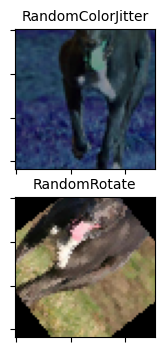

In [69]:
def plot_augmentations(crop: int = 64) -> None:
    # Define transformation for random color jitter
    random_color_jitter = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.RandomCrop((64, 64)),  # Randomly crop image
        transformation.ColorJitter(brightness=(0,5), saturation=(0, 5), hue=(-0.5,0.5)),  # Adjust color jitter
    ])

    # Define transformation for random rotation
    random_rotation = transformation.Compose([
        transformation.ToTensor(),  # Convert image to tensor
        transformation.RandomCrop((64, 64)),  # Randomly crop image
        transformation.RandomRotation(60)  # Randomly rotate
    ])

    # Load data with random color jitter transformation
    random_color_jitter_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=random_color_jitter)
    # Load data with random rotation transformation
    random_rotation_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=random_rotation)

    # Create data loaders
    color_jitter_loader = torch.utils.data.DataLoader(random_color_jitter_data)
    rotation_loader = torch.utils.data.DataLoader(random_rotation_data)

    # Create iterators
    color_jitter_iter = iter(color_jitter_loader)
    rotation_iter = iter(rotation_loader)

    # Create subplots for visualizing examples
    _, axes = plt.subplots(2, 1, figsize=(8, 4))
    axes = axes.flatten()

    # Retrieve examples from data loaders
    for i in range(2):
        color_jitter_example, _ = next(color_jitter_iter)
        rotation_example, _ = next(rotation_iter)

    # Display examples with titles
    axes[0].imshow(np.transpose(torchvision.utils.make_grid(color_jitter_example), (1, 2, 0)))
    axes[0].set_title('RandomColorJitter', fontsize=10)
    axes[1].imshow(np.transpose(torchvision.utils.make_grid(rotation_example), (1, 2, 0)))
    axes[1].set_title('RandomRotate', fontsize=10)

    # Remove ticks from subplots
    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()

plot_augmentations()


### ggg 

In [66]:
go!

SyntaxError: invalid syntax (1886150196.py, line 1)